In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image



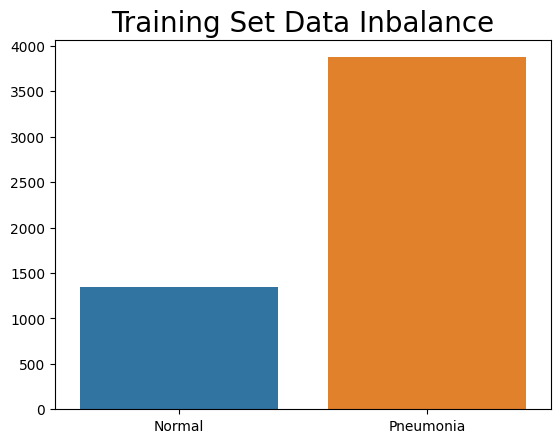

In [4]:
path = '../input/chest-xray/chest_xray/chest_xray'

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

In [5]:
test_d = '../input/chest-xray/chest_xray/chest_xray/test'
train_d= '../input/chest-xray/chest_xray/chest_xray/train'
val_d=os.path.join(path,'val') #another way

(1336, 1128)


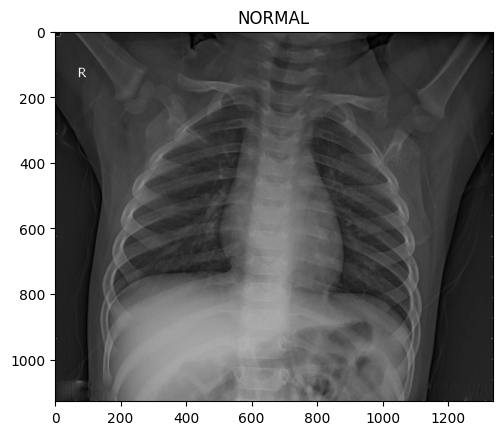

(1024, 712)


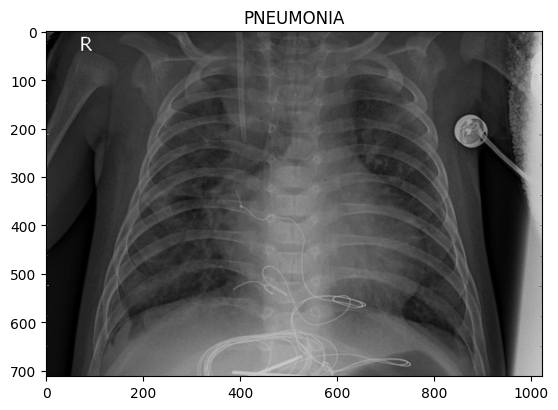

In [6]:
categ = ['NORMAL', 'PNEUMONIA']
for ca in categ:
    path = os.path.join(train_d,ca)
    for img in os.listdir(path):
        img_arr =Image.open(os.path.join(path,img)) 
        print(img_arr.size)
     
        plt.imshow(np.array(img_arr),cmap='gray')
        plt.title(ca)
        plt.show()
        break

In [7]:
# image_pathes=[]
# labels=[]

# files=os.listdir(train_d)
# for file in files:
#     file_path=os.path.join(train_d,file)
#     images=os.listdir(file_path)
#     for image in images:
#         image_path=os.path.join(file_path,image)
#         image_pathes.append(image_path)
#         labels.append(file)
        
# print(image_pathes)
# print(labels)

images=[]
classes=[]
categ = ['NORMAL', 'PNEUMONIA']
for ca in categ:
    path = os.path.join(train_d,ca)
    for img in os.listdir(path):
        image_path= os.path.join(path, img)
        images.append(image_path)
        classes.append(ca)

In [8]:
imageseries=pd.Series(images, name="images")
classseries=pd.Series(classes,name="classes")
train_df=pd.concat([imageseries,classseries],axis=1)

In [9]:
train_df

,images,classes
0,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
1,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
2,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
3,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
4,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
...,...,...
5211,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA
5212,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA
5213,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA
5214,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA


In [10]:
images=[]
classes=[]
categ = ['NORMAL', 'PNEUMONIA']
for ca in categ:
    path = os.path.join(test_d,ca)
    for img in os.listdir(path):
        image_path= os.path.join(path, img)
        images.append(image_path)
        classes.append(ca)

In [11]:
imageseries=pd.Series(images, name="images")
classseries=pd.Series(classes,name="classes")
test_df=pd.concat([imageseries,classseries],axis=1)

In [17]:
test_df.iloc[1,0]

'../input/chest-xray/chest_xray/chest_xray/test/NORMAL/IM-0101-0001.jpeg'

### Dataset

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [20]:
class ChestXray(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')  # Ensure it's in RGB mode
        label = 0 if label == 'NORMAL' else 1

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [21]:
augmented_images_path = './augmented_images/' 

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.ToTensor(),
])

In [23]:
def save_augmented_images(image_path, label, num_augmented_images=5):
    # Open the original image
    image = Image.open(image_path).convert('RGB')

    # Apply augmentation multiple times and save new images
    for i in range(num_augmented_images):
        augmented_image = transform(image)  # Apply the augmentation
        
        # Convert tensor back to PIL image
        augmented_image = transforms.ToPILImage()(augmented_image)

        # Create new file name for augmented image
        base_name = os.path.basename(image_path)
        new_filename = f"{os.path.splitext(base_name)[0]}_aug_{i}.jpg"
        save_path = os.path.join(augmented_images_path, new_filename)

        # Save the augmented image
        augmented_image.save(save_path)
        
        # Optionally, update the dataframe or list with new image path and label
        augmented_df.append([save_path, label])

    return augmented_df


In [24]:
# Create directory to save augmented images if it doesn't exist
if not os.path.exists(augmented_images_path):
    os.makedirs(augmented_images_path)

# List to store augmented images' paths and labels
augmented_df = []

# Loop through original images in train_df
for _, row in train_df.iterrows():
    image_path = row['images']
    label = row['classes']
    
    # Save augmented images for each original image
    augmented_df = save_augmented_images(image_path, label)

# Optionally, create a new dataframe with both original and augmented images
augmented_df = pd.DataFrame(augmented_df, columns=["images", "classes"])

# Combine original dataframe with augmented dataframe
final_train_df = pd.concat([train_df, augmented_df], ignore_index=True, axis=1)


In [25]:
final_train_df

,0,1,2,3
0,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL,./augmented_images/NORMAL2-IM-0771-0001_aug_0.jpg,NORMAL
1,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL,./augmented_images/NORMAL2-IM-0771-0001_aug_1.jpg,NORMAL
2,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL,./augmented_images/NORMAL2-IM-0771-0001_aug_2.jpg,NORMAL
3,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL,./augmented_images/NORMAL2-IM-0771-0001_aug_3.jpg,NORMAL
4,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL,./augmented_images/NORMAL2-IM-0771-0001_aug_4.jpg,NORMAL
...,...,...,...,...
26075,NaN,NaN,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA
26076,NaN,NaN,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA
26077,NaN,NaN,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA
26078,NaN,NaN,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA


In [26]:
train_df

,images,classes
0,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
1,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
2,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
3,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
4,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
...,...,...
5211,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA
5212,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA
5213,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA
5214,../input/chest-xray/chest_xray/chest_xray/trai...,PNEUMONIA


In [27]:
# Create list for augmented data
augmented_data = []

# Generate augmented images
for _, row in train_df.iterrows():
    original_image_path = row['images']
    label = row['classes']
    
    # Save augmented images for each original image
    for i in range(5):  # Number of augmentations
        augmented_image_path = f"./augmented_images/{os.path.basename(original_image_path).split('.')[0]}_aug_{i}.jpg"
        augmented_data.append({'images': augmented_image_path, 'classes': label})


In [29]:
len(augmented_data)

26080

In [30]:
augmented_df = pd.DataFrame(augmented_data)

# Combine original and augmented data
final_train_df = pd.concat([train_df, augmented_df], ignore_index=True)


In [31]:
final_train_df

,images,classes
0,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
1,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
2,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
3,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
4,../input/chest-xray/chest_xray/chest_xray/trai...,NORMAL
...,...,...
31291,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA
31292,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA
31293,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA
31294,./augmented_images/person1051_bacteria_2985_au...,PNEUMONIA


In [34]:
import torchxrayvision as xrv

In [36]:
# Transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transformations for testing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [38]:
train_dataset = ChestXray(final_train_df, transform=train_transform)
test_dataset = ChestXray(test_df, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
train_loader.dataset[31295]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

### Model Training

In [43]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)  

densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 86.0MB/s]


In [44]:
criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet.parameters(), lr=1e-4)
densenet_optimizer = optim.Adam(densenet.parameters(), lr=1e-4)

In [71]:
def train(model, optimizer, criterion, train_loader):
    epochs=10
    model.train()
    for x in range(epochs):
        running_loss = 0.0
        correct = 0
        total=0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs= model(images)
            print("hi")
            loss=criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs, dim=1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
        
        

In [ ]:
train(resnet, resnet_optimizer, criterion, train_loader)

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


In [35]:
model = xrv.models.DenseNet(weights="all")
# does the model align with the dataset?
dict(zip(model.pathologies,xrv.datasets.default_pathologies))

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


{'Atelectasis': 'Atelectasis',
 'Consolidation': 'Consolidation',
 'Infiltration': 'Infiltration',
 'Pneumothorax': 'Pneumothorax',
 'Edema': 'Edema',
 'Emphysema': 'Emphysema',
 'Fibrosis': 'Fibrosis',
 'Effusion': 'Effusion',
 'Pneumonia': 'Pneumonia',
 'Pleural_Thickening': 'Pleural_Thickening',
 'Cardiomegaly': 'Cardiomegaly',
 'Nodule': 'Nodule',
 'Mass': 'Mass',
 'Hernia': 'Hernia',
 'Lung Lesion': 'Lung Lesion',
 'Fracture': 'Fracture',
 'Lung Opacity': 'Lung Opacity',
 'Enlarged Cardiomediastinum': 'Enlarged Cardiomediastinum'}